<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     

## <center> Kaggle inclass competition from [mlcourse.ai](https://mlcourse.ai/)
    
# <center> [**Catch me if you can**](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

### <center> Session: Fall 2019

#### <div style="text-align: right"> Author: [Vladimir Kulyashov](https://github.com/koolvn)


<div style="text-align: right"> creation date: 15 October 2019 </div>

In [1]:
# imports and constants
import os
import pickle
import numpy as np
import pandas as pd
import time
import eli5
from contextlib import contextmanager
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt


PATH_TO_DATA = '../data/alice/'
AUTHOR = 'Vladimir_Kulyashov'

# most of hyperparams here

vectorizer_params={'ngram_range': (1, 5),
                   'max_features': 50000,
                   'tokenizer': lambda s: s.split()}
SEED = 17
N_JOBS = 4
NUM_TIME_SPLITS = 10    # for time-based cross-validation
SITE_NGRAMS = (1, 5)    # site ngrams for "bag of sites"
MAX_FEATURES = 50000    # max features for "bag of sites"
BEST_LOGIT_C = 0.01 # precomputed tuned C for logistic regression

### Useful def's from public notebooks

In [2]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
%%time
# Read the training and test data sets, change paths if needed

times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(PATH_TO_DATA + 'train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA + 'test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head(3)

Wall time: 5.47 s


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0


In [4]:
%%time
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(PATH_TO_DATA + 'site_dic.pkl', "rb") as input_file:
    site_dict = pickle.load(input_file)
     
# create an inverse id _> site mapping
id2site = {v:k for (k, v) in site_dict.items()}
# we treat site with id 0 as "unknown"
id2site[0] = 'unknown'
    
vectorizer = TfidfVectorizer(**vectorizer_params)

train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()

X_train_sites = vectorizer.fit_transform(train_sessions)
X_test_sites = vectorizer.transform(test_sessions)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head(3)

Websites total: 48371
Wall time: 37 s


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com


In [5]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(15)
# print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com
812,mail.google.com


In [6]:
top_alice_sites = pd.Series(train_df[train_df['target'] == 1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(15)
sites_dict.loc[top_alice_sites.index]

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['start'] = train_df[times].min(axis=1)
time_df['end'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['end'] - time_df['start']) / np.timedelta64(1, 's')

# Calculate sessions' duration in minutes
time_df['minutes'] = (time_df['end'] - time_df['start']) / np.timedelta64(1, 's')/60

time_df.head(3)

,target,start,end,seconds,minutes
session_id,,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,0.000000
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,29.766667
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,0.066667


In [8]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946


In [9]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 

full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [10]:
# Getting lists of sites
facebook_ids = []
youtube_ids = []
google_ids = []

for key in list(site_dict.keys()):
    if 'facebook' in key:
        facebook_ids.append(site_dict[key])
    if 'youtube' in key:
        youtube_ids.append(site_dict[key])
    if 'google' in key:
        google_ids.append(site_dict[key])

### New Features

In [11]:
%%time
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# start_month
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

# start_day
full_new_feat['start_day'] = full_df['time1'].apply(lambda ts: ts.weekday()).astype('float64')

# # n_unique_sites
# full_new_feat['n_unique_sites'] = full_sites.nunique(axis=1)

# start_hour
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)

# start_minute
full_new_feat['start_minute'] = full_df['time1'].apply(lambda ts: ts.minute)

# start_hour_minute
full_new_feat['start_hour_minute'] = full_df['time1'].apply(lambda ts: ts.hour)*100+full_df['time1'].apply(lambda ts: ts.minute)

# part of the day
full_new_feat['morning'] = ((full_new_feat['start_hour'] >= 0) & (full_new_feat['start_hour'] <= 11)).astype(int)
full_new_feat['day'] = ((full_new_feat['start_hour'] >= 12) & (full_new_feat['start_hour'] <= 18)).astype('int')
full_new_feat['evening'] = ((full_new_feat['start_hour'] >= 19) & (full_new_feat['start_hour'] <= 23)).astype('int')

# Youtube
full_new_feat['youtube'] = full_df['site1'].apply(lambda x: 1 if x in youtube_ids else 0)

# Facebook
full_new_feat['fb'] = full_df['site1'].apply(lambda x: 1 if x in facebook_ids else 0)

full_new_feat.head(3)

Wall time: 12.8 s


,start_month,start_day,start_hour,start_minute,start_hour_minute,morning,day,evening,youtube,fb
session_id,,,,,,,,,,
21669,201301.0,5.0,8,5,805,1,0,0,0,0
54843,201301.0,5.0,8,37,837,1,0,0,0,0
77292,201301.0,5.0,8,50,850,1,0,0,0,0


### Training model

In [12]:
%%time
# Add the new features to the sparse matrix
no_scale = full_new_feat.drop(columns=["start_hour_minute",
                                       "start_month",
                                       "start_minute",
                                       "start_hour"]
                             ).values
scaled = MinMaxScaler().fit_transform(full_new_feat[
    ["start_month",
     "start_hour",
     "start_minute",
     "start_hour_minute",
     "morning",
     "day",
     "evening",
     "youtube",
     "fb"]
])

full_scaled = MinMaxScaler().fit_transform(full_new_feat)

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             no_scale[:idx_split,:],
                             scaled[:idx_split,:]
                            ]))

X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:],
                             no_scale[idx_split:,:],
                             scaled[idx_split:,:]
                            ]))

# Compute the metric on the validation set
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)


0.975052111260863
Wall time: 12.1 s


### Cross-validation

In [13]:
%%time
time_split = TimeSeriesSplit(n_splits=NUM_TIME_SPLITS)

logit = LogisticRegression(random_state=SEED, solver='liblinear')

# Cs = [0.05, 0.1, 0.5]
Cs = np.logspace(-3, 1, 10)
# Cs = [BEST_LOGIT_C]

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': Cs},
                              scoring='roc_auc', n_jobs=N_JOBS, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train, y_train)

print('CV score', logit_grid_searcher.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.9min finished


CV score 0.9168243260871198
Wall time: 3min 1s


In [14]:
print(f"std = {logit_grid_searcher.cv_results_['std_test_score'].mean() : .5}")
logit_grid_searcher.best_estimator_

std =  0.09965


LogisticRegression(C=0.46415888336127775, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
logit_grid_searcher.best_params_

{'C': 0.46415888336127775}

In [16]:
%%time
# List of possible C-values
# Cs = np.logspace(-3, 1, 10)
# Cs = np.linspace(1e-10, 1, num=10)
# Cs = [0.05, 0.1, 0.15]
# Cs = [0.05994842503189409, 1]

best_C = {}
for C in Cs:
    score = get_auc_lr_valid(X_train, y_train, C=C)
    best_C.update({score: C})
    
print(f'Best C = {best_C[max(best_C.keys())]}\nROC_AUC = {max(best_C.keys())}')

Best C = 0.1668100537200059
ROC_AUC = 0.9778611678719282
Wall time: 1min 8s


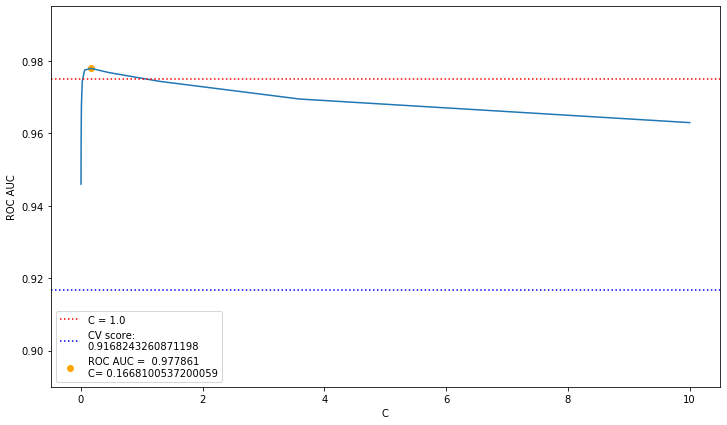

In [17]:
plt.figure(figsize=(12,7))
plt.plot(list(best_C.values()), list(best_C.keys()))
plt.axhline(score_C_1, ls='dotted', c='red', label='C = 1.0')
plt.axhline(logit_grid_searcher.best_score_, ls='dotted', c='blue', label=f'CV score:\n{logit_grid_searcher.best_score_}')
plt.ylabel('ROC AUC')
plt.xlabel('C')
# plt.xlim((-0.1,1.75))
plt.ylim((0.89, 0.995))
plt.scatter(best_C[max(best_C.keys())], max(best_C.keys()), c='orange', alpha=1, label=f'ROC AUC = {max(best_C.keys()): .6}\nC= {best_C[max(best_C.keys())]}')

# plt.annotate(f'C = {best_C[max(best_C.keys())]: .2}',
#              xy=(best_C[max(best_C.keys())],
#                  max(best_C.keys())),
#              xytext=(best_C[max(best_C.keys())]-0.05,
#                      max(best_C.keys())+0.0009))

plt.legend()
plt.show()

### Write it to the submission file

In [18]:
y_test = logit_grid_searcher.predict_proba(X_test)[:, 1]

write_to_submission_file(y_test, 'alice_submission.csv')

In [19]:
# from sklearn.decomposition import PCA, TruncatedSVD # PCA - 0.959134853436324, SVD - 0.957289673999681

In [20]:
# plt.hist(time_df[(time_df['target']==1) & (time_df['seconds']<100)]['seconds']);
# alice_sessions = time_df[time_df['target']==1].sort_values(['start'])
# number_of_alice_sessions = time_df[time_df['target']==1]['target'].count()
# alice_sessions['seconds'].describe()
# # time_df[(time_df['target']==1) & (time_df['seconds'] >=300)]['target'].count()

In [21]:
# alice_sessions['day'] = alice_sessions['start'].apply(lambda t: t.weekday())
# number_of_sessions_by_weekdays = alice_sessions.groupby(
#     alice_sessions['start'].apply(lambda t: t.day_name()))['seconds'].count()
# duration_of_sessions_by_weekdays = alice_sessions.groupby(
#     alice_sessions['start'].apply(lambda t: t.day_name()))['seconds'].sum()

# plt.hlines(0, -1, 7)
# plt.plot(number_of_sessions_by_weekdays);

In [22]:
# plt.hlines(0, -1, 7)
# plt.plot(duration_of_sessions_by_weekdays);